In [2]:
%%javascript
IPython.notebook.get_cells().map( function(c) {  return c.code_mirror.options.cursorBlinkRate=0;  } );
CodeMirror.defaults.cursorBlinkRate=0;

<IPython.core.display.Javascript object>

# Self-Supervised Learning Example

This is a small scale example for self-supervised learning (SSL) in computer vision, using the MNIST data set (classification).

The SSL approach follows https://arxiv.org/abs/2105.04906 (VICReg).

## General preparations

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as torch_fct
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as tv_datasets
import torchvision.transforms as tv_transforms

import numpy as np

USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print("using device : ", device)

using device :  cuda


In [3]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['figure.facecolor']    = 'White'
plt.rcParams['font.size']    = 8

## Get all datasets

Apart from the usual training, validation and test datasets, also prepare two training datasets for SSL: same images, but different crops. Each crop is considered a different view of its associated full image.

In [4]:
NUM_TRAIN = 49000

transform = tv_transforms.Compose([ tv_transforms.ToTensor(),
                                    tv_transforms.Normalize((0.13066047797803165), (0.308107814120828)) ])
transform_rnd_crop = tv_transforms.Compose([ tv_transforms.ToTensor(),
                                             tv_transforms.Normalize((0.13066047797803165), (0.308107814120828)),
                                             tv_transforms.RandomCrop( size = ( 14, 14 ) ) ])

mnist_train                   = tv_datasets.MNIST('./cs231n/datasets', train=True, download=True,
                                       transform=transform)
mnist_train_rnd_crop_1        = tv_datasets.MNIST( './cs231n/datasets', train=True, download=True,
                                                      transform = transform_rnd_crop )
mnist_train_rnd_crop_2        = tv_datasets.MNIST( './cs231n/datasets', train=True, download=True,
                                                      transform = transform_rnd_crop )
loader_train_mnist            = DataLoader( mnist_train, batch_size=500, 
                                            sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)) )

mnist_val = tv_datasets.MNIST('./cs231n/datasets', train=True, download=True,
                               transform=transform)
loader_val_mnist = DataLoader(mnist_val, batch_size=500,
                              sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))

mnist_test = tv_datasets.MNIST('./cs231n/datasets', train=False, download=True, 
                               transform=transform)
loader_test_mnist = DataLoader(mnist_test, batch_size=64)

## Linear classifier as the baseline

A linear function is used to classify the MNIST dataset -> accuracy 84 %.
The SSL approach implemented further below is supposed to surpass this accuracy.

In [6]:
class LinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.ll = nn.Linear( input_size, output_size )
        nn.init.kaiming_normal_(self.ll.weight)
    
    def forward(self, x):
        x = x.view( x.shape[0], -1 )
        scores = self.ll(x)
        return scores

In [7]:
def get_accuracy(model, dl):
    if dl.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        for x, y in dl:
            x               = x.to(device=device, dtype=torch.float32)
            y               = y.to(device=device, dtype=torch.int64)
            scores          = model(x)
            _, predictions  = scores.max(1)
            num_correct    += ( predictions == y ).sum().item()
            num_samples    += predictions.size(0)
        accuracy = float( num_correct ) / float( num_samples )
        print( "Accuracy = {} %".format( int( ( num_correct / num_samples ) * 100 ) ) )  

In [8]:
def train(model, optimizer, dl_train, dl_val, n_epochs = 1):
    model = model.to(device)
    for i_epoch in range( n_epochs ):
        for t, (x, y) in enumerate( dl_train ):
            model.train()
            x = x.to(device=device, dtype=torch.float32)
            y = y.to(device=device, dtype=torch.long)
            scores = model( x )
            loss   = torch_fct.cross_entropy( scores, y )
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print("epoch", i_epoch, ":")
        get_accuracy( model, dl_val )
        print()

In [11]:
model = LinearModel( 28 * 28, 10 )

x, y = loader_train_mnist.dataset[0]

optimizer = optim.SGD( model.parameters(), lr = 3e-4, momentum = 0.8 )
train(model, optimizer, loader_train_mnist, loader_val_mnist, 30)

epoch 0 :
Checking accuracy on validation set
Accuracy = 39 %

epoch 1 :
Checking accuracy on validation set
Accuracy = 57 %

epoch 2 :
Checking accuracy on validation set
Accuracy = 64 %

epoch 3 :
Checking accuracy on validation set
Accuracy = 68 %

epoch 4 :
Checking accuracy on validation set
Accuracy = 71 %

epoch 5 :
Checking accuracy on validation set
Accuracy = 73 %

epoch 6 :
Checking accuracy on validation set
Accuracy = 74 %

epoch 7 :
Checking accuracy on validation set
Accuracy = 75 %

epoch 8 :
Checking accuracy on validation set
Accuracy = 76 %

epoch 9 :
Checking accuracy on validation set
Accuracy = 78 %

epoch 10 :
Checking accuracy on validation set
Accuracy = 79 %

epoch 11 :
Checking accuracy on validation set
Accuracy = 79 %

epoch 12 :
Checking accuracy on validation set
Accuracy = 80 %

epoch 13 :
Checking accuracy on validation set
Accuracy = 80 %

epoch 14 :
Checking accuracy on validation set
Accuracy = 81 %

epoch 15 :
Checking accuracy on validation set
Acc

 # SSL Dataset

In [13]:
class SSLDataset(Dataset):
    """
    Create a dataset suitable for SSL, using two datasets which represent different views of the same image.
    For each entry, both datasets must contain the same label.
    """
    def __init__( self, ds1, ds2 ):
        assert len(ds1) == len(ds2)
        assert ds1[0][0].dtype == ds2[0][0].dtype
        assert type( ds1[0][1] ) == type( ds2[0][1] )
        for i_entry in range( len( ds1 ) ):
            _, y_1 =  ds1[i_entry]
            _, y_2 =  ds2[i_entry]
            assert y_1 == y_2
        self.ds1 = ds1
        self.ds2 = ds2
        
    def __len__( self ):
        return len( self.ds1 )
    
    def __getitem__( self, idx ):
        x_1, y  = self.ds1[idx]
        x_2, _  = self.ds2[idx]
        return ( x_1, x_2 ), y

ds_ssl = SSLDataset( mnist_train_rnd_crop_1, mnist_train_rnd_crop_2 )

## SSL Model
We use a model suitable for image data to perform SSL: two convolutional layers, each with batch normalisation, max pooling and ReLU non-linearity. This defines the "backbone" network denoted $f_{\theta}$ in the VICReg paper. The expander, denoted $h_{\phi}$ in the paper, is an MLP. We use the same networks for both views ($\theta'$ = $\theta$ and $\phi$ = $\phi'$).


<img src="VICReg.png"/>




In [16]:
class SSLNet(nn.Module):
    def __init__( self, n_channels_in, n_layers_backbone_last, n_nodes_expander ):
        super().__init__()
        
        self.bb_conv_1    = nn.Conv2d( n_channels_in, 8, 5, padding = 2 )
        nn.init.kaiming_normal_( self.bb_conv_1.weight )
        self.bb_bn_1      = nn.BatchNorm2d( 8 )
        self.bb_maxpool_1 = nn.MaxPool2d( 2 )
        self.bb_conv_2    = nn.Conv2d( 8, n_layers_backbone_last, 4, padding = 1 )
        nn.init.kaiming_normal_( self.bb_conv_2.weight )
        self.bb_bn_2      = nn.BatchNorm2d( n_layers_backbone_last )
        self.bb_maxpool_2 = nn.MaxPool2d( 2 )
        
        self.exp_fc_1 = nn.Linear( n_layers_backbone_last * 3**2, n_nodes_expander )
        nn.init.kaiming_normal_( self.exp_fc_1.weight )
        self.exp_bn_1 = nn.BatchNorm1d( n_nodes_expander )
        self.exp_fc_2 = nn.Linear( n_nodes_expander, n_nodes_expander )
        nn.init.kaiming_normal_( self.exp_fc_2.weight )
        
    def forward_backbone(self, x):
        x = torch_fct.relu( self.bb_bn_1( self.bb_conv_1( x ) ) )
        x = self.bb_maxpool_1( x )
        x = torch_fct.relu( self.bb_bn_2( self.bb_conv_2( x ) ) )
        x = self.bb_maxpool_2( x )
        y = x.view(x.shape[0], -1)
        return y
        
    def forward_expander(self, y):
        y = torch_fct.relu( self.exp_bn_1( self.exp_fc_1( y ) ) )
        z = self.exp_fc_2( y )
        return z
    
    def forward(self, x):
        y = self.forward_backbone( x )
        z = self.forward_expander( y )
        return z

ssl_model = SSLNet( 1, 12, 250 )
dl_ssl    = DataLoader( ds_ssl, batch_size = 500, sampler=sampler.SequentialSampler(range(30000)) ) # restricted the dataset size in order to shorten the training time

## SSL Training

We use a VICReg loss function, along the lines of the paper. In particular, the same hyperparameters are chosen for the loss function coefficients.

In [21]:
def train_ssl( model, optimizer, data_loader, n_epochs = 1 ):
    
    model        = model.to(device)
    loss_fct_mse = nn.MSELoss()
    
    loss_mse_all = []
    loss_std_all = []
    loss_cov_all = []
    loss_sum_all = []
    
    for i_epoch in range( n_epochs ):
        for t, (XX, _) in enumerate( data_loader ):
            
            model.train()
            x_1 = XX[0].to( device, dtype = torch.float32 )
            x_2 = XX[1].to( device, dtype = torch.float32 )
            z_1 = model( x_1 )
            z_2 = model( x_2 )
            
            loss_mse = loss_fct_mse( z_1, z_2 )
            loss_mse_all.append( loss_mse.detach().cpu() )
            
            std_z_1   = torch.sqrt( z_1.var( dim = 0 ) + 1e-4 )
            std_z_2   = torch.sqrt( z_2.var( dim = 0 ) + 1e-4 )
            loss_std  = torch.mean( torch_fct.relu( 1.0 - std_z_1 ) ) + torch.mean( torch_fct.relu( 1.0 - std_z_2 ) )
            loss_std_all.append( loss_std.detach().cpu() )
            
            z_1        = z_1 - z_1.mean( dim = 0 )
            z_2        = z_2 - z_2.mean( dim = 0 )
            batch_size = z_1.shape[0]
            exp_size   = z_1.shape[1]
            cov_1      = z_1.T @ z_1 / ( batch_size - 1 )
            cov_2      = z_2.T @ z_2 / ( batch_size - 1 )
            loss_cov = 0.0
            for i_row in range(1, exp_size - 1):
                for i_column in range(i_row + 1, exp_size):
                    loss_cov += 2.0 * ( cov_1[i_row][i_column]**2 + cov_2[i_row][i_column]**2 ) / exp_size
            loss_cov_all.append( loss_cov.detach().cpu() )
            
            loss_sum = 25.0 * loss_mse + 25.0 * loss_std + 1.0 * loss_cov
            loss_sum_all.append( loss_sum.detach().cpu() )
            
            optimizer.zero_grad()
            loss_sum.backward()
            optimizer.step()
            
            if t % 1 == 0:
                print("Epoch {}, iteration {} : loss mse, std, cov = {}, {}, {}".format( i_epoch, t * batch_size, loss_mse_all[-1], loss_std_all[-1], loss_cov_all[-1] ) )
    
    return { "sum" : loss_sum_all,
             "mse" : loss_mse_all,
             "std" : loss_std_all,
             "cov" : loss_cov_all }

Epoch 0, iteration 0 : loss mse, std, cov = 1.263320803642273, 0.27022677659988403, 4.547415256500244
Epoch 0, iteration 500 : loss mse, std, cov = 1.2050282955169678, 0.3159358501434326, 3.872286558151245
Epoch 0, iteration 1000 : loss mse, std, cov = 1.1330249309539795, 0.35493987798690796, 3.9316139221191406
Epoch 0, iteration 1500 : loss mse, std, cov = 1.1037119626998901, 0.38783514499664307, 3.1407806873321533
Epoch 0, iteration 2000 : loss mse, std, cov = 1.0636707544326782, 0.4195724129676819, 2.69088077545166
Epoch 0, iteration 2500 : loss mse, std, cov = 1.0431727170944214, 0.44917625188827515, 2.4916329383850098
Epoch 0, iteration 3000 : loss mse, std, cov = 1.0230759382247925, 0.47226446866989136, 2.203735589981079
Epoch 0, iteration 3500 : loss mse, std, cov = 0.9762941598892212, 0.5044240951538086, 1.9838652610778809
Epoch 0, iteration 4000 : loss mse, std, cov = 0.9250277280807495, 0.5363767743110657, 1.8295432329177856
Epoch 0, iteration 4500 : loss mse, std, cov = 0.88

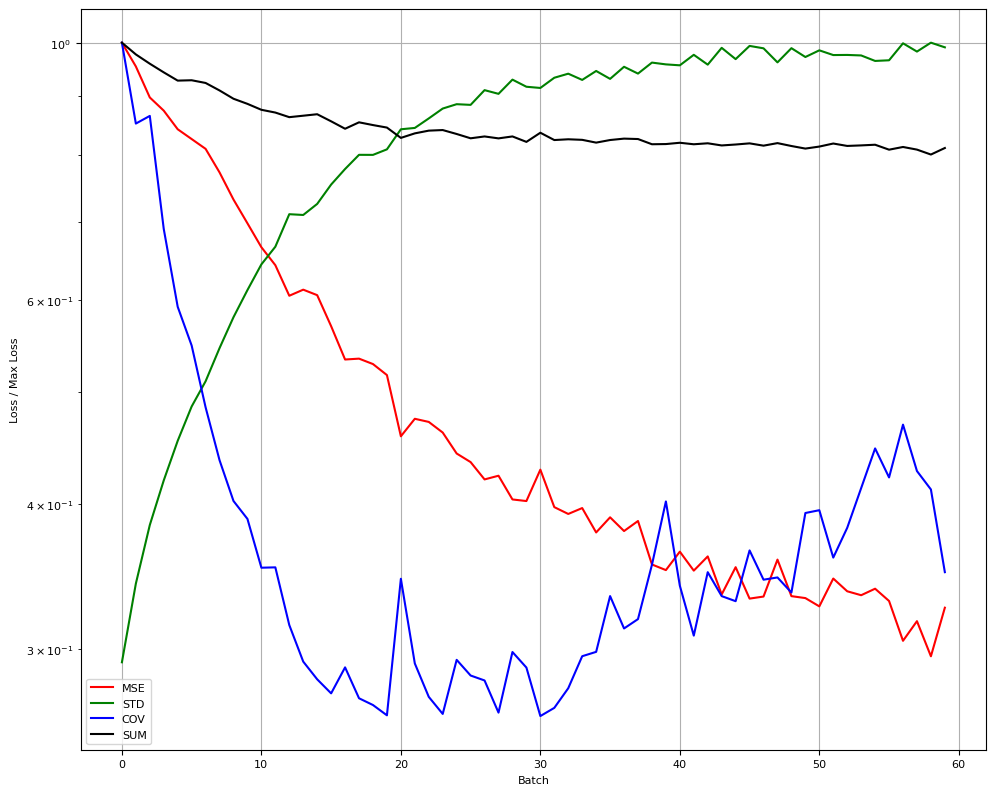

In [22]:
optimizer = optim.Adam( ssl_model.parameters(), lr = 1e-3, weight_decay = 1e-2 )
losses    = train_ssl( ssl_model, optimizer, dl_ssl, 1 )

loss_sum_all = losses[ "sum" ]
loss_mse_all = losses[ "mse" ]
loss_std_all = losses[ "std" ]
loss_cov_all = losses[ "cov" ]

plt.plot( [ x / max( loss_mse_all ) for x in loss_mse_all ], color = "r", label = "MSE" )
plt.plot( [ x / max( loss_std_all ) for x in loss_std_all ], color = "g", label = "STD" )
plt.plot( [ x / max( loss_cov_all ) for x in loss_cov_all ], color = "b", label = "COV" )
plt.plot( [ x / max( loss_sum_all ) for x in loss_sum_all ], color = "k", label = "SUM" )
plt.ylabel( "Loss / Max Loss" )
plt.xlabel( "Batch" )
plt.yscale( "log" )
plt.legend()
plt.grid(True)
plt.tight_layout()    
plt.show()

## Downstream task: SSL pre-trained model + one linear layer for classification
Now we use the data representation learned via SSL in order to classify the MNIST dataset. As above, we will simply use a linear classifier. Only the weights of this last linear layer will be subject to the supervised learning. The weights of the SSL backbone will be frozen. The resulting accuracy of 90 %, greater than the 84 % accuracy achieved before without the SSL pre-training, shows that the SSL pre-training indeed captured useful information.

This example is not fully optimised and further improvement is clearly possible, as reported in the VICReg paper. Anyway, you get the idea.

In [23]:
class SSLBasedLinearModel(nn.Module):
    def __init__(self, ssl_pretrained_model, n_classes ):
        super().__init__()
        self.ssl_pretrained_model = ssl_pretrained_model
        self.fc_layer             = nn.Linear( 432, n_classes )
        nn.init.kaiming_normal_(self.fc_layer.weight)
        
    def forward(self, x):
        y      = self.ssl_pretrained_model.forward_backbone( x ).detach() # detach : Do not change the backbone derived previously from SSL
        scores = self.fc_layer( y )
        return scores

downstream_model = SSLBasedLinearModel( ssl_model, 10 )
downstream_model = downstream_model.to(device)
# some testing
x, _             = next( iter ( loader_train_mnist ) )
x                = x.to(device)
downstream_model( x )

tensor([[-2.3017, -0.6764, -1.6045,  ...,  0.1988,  2.3505, -0.9377],
        [-0.7825, -1.6923, -1.7792,  ..., -1.2944,  3.6741, -0.5963],
        [-2.8156, -4.0666, -2.8148,  ..., -0.7618,  3.5772,  0.6305],
        ...,
        [-2.5174, -1.7040, -1.3409,  ...,  1.0166,  0.1625,  0.5746],
        [-3.7342, -1.0441, -2.9163,  ..., -0.0967,  1.1363,  0.2702],
        [-4.0968, -1.0466,  1.6327,  ...,  2.1503,  0.1793, -0.3221]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [24]:
optimizer = optim.SGD( downstream_model.parameters(), lr = 1e-3, momentum = 0.8 )
train( downstream_model, optimizer, loader_train_mnist, loader_val_mnist, 10 )

epoch 0 :
Checking accuracy on validation set
Accuracy = 49 %

epoch 1 :
Checking accuracy on validation set
Accuracy = 69 %

epoch 2 :
Checking accuracy on validation set
Accuracy = 78 %

epoch 3 :
Checking accuracy on validation set
Accuracy = 81 %

epoch 4 :
Checking accuracy on validation set
Accuracy = 84 %

epoch 5 :
Checking accuracy on validation set
Accuracy = 86 %

epoch 6 :
Checking accuracy on validation set
Accuracy = 87 %

epoch 7 :
Checking accuracy on validation set
Accuracy = 88 %

epoch 8 :
Checking accuracy on validation set
Accuracy = 90 %

epoch 9 :
Checking accuracy on validation set
Accuracy = 90 %

